# Classification Training Notebook

Notebook for the Training of a Classification, 2 possible classifications:
- Mnist dataset (numbers)
- Animals

TO-DO: Descargar tf_flowers en un directorio, para probar con el mnist y flowers, asi probar temas rgb

## =========== Imports ===========

In [1]:
# Libraries necessaries for the constants
import os

# Set tensorflow to work with CPU and not GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import time
import datetime

# Dataframe libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Tensorflow libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
import keras.models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, average_precision_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import random
import zipfile
import itertools

## =========== Constants ===========

Dataset to use

In [2]:
dataset = "mnist"
# dataset = "animal"

#### DataSet Information
- *CLASSES*: Classes Labels
- *CLASS_NUMBER*: Number of Classes Labels
- *CLASS_DICTIONARY*: Dictionary with the labels

In [3]:
if dataset == "mnist":
    CLASSES = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9" ]
elif dataset == "animal":
    CLASSES = ["Bear", "Chicken", "Turtle"]

assert CLASSES

CLASS_NUMBER = len(CLASSES)

# Ensure that all the labels are strings
CLASSES =[str(item) for item in CLASSES]

CLASS_DICTIONARY = {}
for idx, clas in enumerate(CLASSES):
    CLASS_DICTIONARY[clas] = idx

#### DataSets
- *DATASETS_ROOT_FOLDER*: Folder where the dataset is
- *CSV_FOLDER*: Folder with the CSVs
    - *TRAIN_CSV* : Train csv name
    - *TEST_CSV* : Test csv name
    - *VALIDATION_CSV* : Validation csv name

In [4]:
########################################
# Image Dataset

# Path to root image folders
DATASETS_ROOT_FOLDER = "../../datasets/"

if dataset == "mnist":
    DATASET_FOLDER = "mnist/"
elif dataset == "animal":
    DATASET_FOLDER = "data/"

assert DATASET_FOLDER

# DATASETS_ROOT_FOLDER = os.path.abspath(DATASETS_ROOT_FOLDER) + os.sep

########################################
# CSV dataset

# Path to csv-dataset files
CSV_FOLDER = "../../csv/"
#CSV_FOLDER = os.path.abspath(CSV_FOLDER) + os.sep

# CSV-DATASET FILE NAMES

if dataset == "mnist":
    TRAIN_CSV = "mnist_train.csv"
    TEST_CSV = "mnist_test.csv"
    VALIDATION_CSV = "mnist_val.csv"
elif dataset == "animal":
    TRAIN_CSV = "data_train.csv"
    TEST_CSV = "data_test.csv"
    VALIDATION_CSV = "data_val.csv"

assert TRAIN_CSV, TEST_CSV and VALIDATION_CSV


#### Model
- *MODEL_PATH*: Path to find the saved models
- *MODEL_SAVE_FOLDER*: Path to save the models


In [5]:
########################################
# Model and weights defined together

# Path to the model+weights of the model
MODEL_PATH = "../../models/v6"

########################################
# Path to folder where to save the model

MODEL_SAVE_FOLDER = "../../models/v6/"
MODEL_SAVE_FOLDER = os.path.abspath(MODEL_SAVE_FOLDER) + os.sep

#### Train
Training Parameters

In [6]:
SHUFFLE = True

BATCH_NUMBER = 64

# The number of epochs is repeated during the training_loops_Dataset_renewal
TRAINING_LOOPS_DATASETS_RENEWAL = 3     # Period of dataset renewal
EPOCHS = 10                              # Total / Max number of epochs that are going to be runned
# So training for 9 epochs, and every 3 epochs dataset will be renewed (3 different datasets)

FROM_LOGITS = True
MODEL_PATH = MODEL_PATH
MODEL_NAME = "test_model"

LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=FROM_LOGITS)

METRICS = [accuracy_score, recall_score, precision_score, f1_score]

PATIENCE_EARLY_STOPPING = 5

###################################################
# Size/shape of images (when resized)

if dataset == "mnist":
    IMG_WIDTH = 28
    IMG_HEIGHT = 28
    N_CHANNELS = 1
    COLOR_MODE = "grayscale"
elif dataset == "animal":
    IMG_WIDTH = 128
    IMG_HEIGHT = 128
    N_CHANNELS = 3
    COLOR_MODE = "rgb"

assert IMG_HEIGHT, IMG_WIDTH and N_CHANNELS

#################################################################################
# Lists

IMG_EXTENSIONS = ['jpg', 'JPG', 'png', 'PNG']

# ======== Code ========

## Helper - functions ;)

Help functions from the repository https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

that are very helpful for machine learning

In [7]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
# from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=IMG_WIDTH, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).

    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        # Rescale the image (get all values between 0 and 1)
        return img / 255.
    else:
        return img


# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    if len(pred[0]) > 1:  # check for multi-class
        pred_class = class_names[pred.argmax()]  # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])]  # if only one output, round

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);


def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instand to store log files.

    Stores log files with the filepath:
      "dir_name/experiment_name/current_datetime/"

    Args:
      dir_name: target directory to store TensorBoard log files
      experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
      history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();


def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs - 1, initial_epochs - 1],
             plt.ylim(), label='Start Fine Tuning')  # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs - 1, initial_epochs - 1],
             plt.ylim(), label='Start Fine Tuning')  # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


# Create function to unzip a zipfile into current working directory
# (since we're going to be downloading and unzipping a few files)

def unzip_data(filename):
    """
    Unzips filename into the current working directory.

    Args:
      filename (str): a filepath to a target zip folder to be unzipped.
    """
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()


# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.


def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.

    Args:
      dir_path (str): target directory

    Returns:
      A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


# Function to evaluate: accuracy, precision, recall, f1-score
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

## Data

Loading, transformation and preprocessing

### Load and transform Data

In [8]:
# Walk through each directory to count the number of instances per class
dataset = DATASETS_ROOT_FOLDER + DATASET_FOLDER
walk_through_dir(dataset);

There are 10 directories and 0 images in '../../datasets/mnist/'.
There are 0 directories and 4132 images in '../../datasets/mnist/0'.
There are 0 directories and 4684 images in '../../datasets/mnist/1'.
There are 0 directories and 4177 images in '../../datasets/mnist/2'.
There are 0 directories and 4351 images in '../../datasets/mnist/3'.
There are 0 directories and 4072 images in '../../datasets/mnist/4'.
There are 0 directories and 3795 images in '../../datasets/mnist/5'.
There are 0 directories and 4137 images in '../../datasets/mnist/6'.
There are 0 directories and 4401 images in '../../datasets/mnist/7'.
There are 0 directories and 4063 images in '../../datasets/mnist/8'.
There are 0 directories and 4188 images in '../../datasets/mnist/9'.


### Placing data into a Dataframe
The first column filepaths contains the file path location of each individual images. The second column labels, on the other hand, contains the class label of the corresponding image from the file path

##### Auxiliar Functions

In [9]:
# get_min(dataframe)
# given a dataframe returns the value of instances of the class with fewer
# instances (minimum class)
def get_min(dataframe):

    min_class = list(dataframe['label'].value_counts())[-1]

    return min_class


# create_pd_dataframe(data_csv, csv_folder = CSV_FOLDER)
# given the name of the csv and the folder where it is located, create a pandas dataframe with its content
# and modify the class from string to number with the class dictionary in constants
def create_pd_dataframes(data_csv, csv_folder = CSV_FOLDER):
    data_panda = pd.read_csv(os.path.join(csv_folder, data_csv))

    # Añadir el path absoluto (la parte desde C:// ... hasta animals al inicio para poder acceder
    data_panda["path"] = [DATASETS_ROOT_FOLDER + item for item in data_panda["path"]]

    data_panda["label"] = [CLASS_DICTIONARY[str(item)] for item in data_panda["label"]]

    return data_panda


# balance_df_classes(dataframe, mini = 0)
# given a (pandas) dataframe and the minimum name of instances we want per classs, it create a balaced dataframe
def balance_df_classes(dataframe, mini = 0):
    new_dataframe = pd.DataFrame([])

    min_class = get_min(dataframe)

    # To add a minimum number of images per class in the case of entering it by parameters
    if mini > min_class:
        min_class = mini

    # for each class take the min number of imgs that must be taken to create the dataframe
    for clas in list(np.unique(dataframe['label'])):
        current_dataframe = (dataframe[dataframe['label'] == clas])

        aux = current_dataframe.sample(n = min_class, replace = True)

        # y lo concatena con el que ya teniamos
        new_dataframe = pd.concat([new_dataframe,aux])

    return new_dataframe

# create_balanced_dataframes(data_csv, csv_folder = CSV_FOLDER, mini = 0)
# calls the functions that create the dataframes and balance them
def create_balanced_dataframes(data_csv, csv_folder = CSV_FOLDER, mini = 0):

    pandas_dataframe = create_pd_dataframes(data_csv, csv_folder)
    pandas_dataframe_balanced = balance_df_classes(pandas_dataframe, mini)

    return pandas_dataframe_balanced


# create_tf_ds(dataframe)
# from a dataframe, it creates a tensorflow dataset
def create_tf_ds(dataframe):

    num_instances = int(np.floor(len(dataframe) / BATCH_NUMBER))

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  )


    # TODO funciones especificas -> data image generator para el data augmentation -> buscar en internet cualquier metodo para hacerlo, copiar todo desde esta celda hacia arriba para el notebook de data augmentation. Progrmaar "todas" y coger las más relevantes al final (giro, intensidad, etc). Pero tener todas hechas y dejar comentadas las que no queramos usar.

    tf_dataset = datagen.flow_from_dataframe(
                            dataframe,
                            x_col = 'path',
                            y_col = 'label',
                            target_size = (IMG_WIDTH,IMG_HEIGHT),
                            color_mode = 'rgb', # rgb
                            batch_size = BATCH_NUMBER,
                            shuffle = SHUFFLE,
                            interpolation = "bicubic",  # to descrease, increase
                            class_mode='raw' # categorical -> str , raw = numbers
                            )

    return num_instances, tf_dataset

def create_tensorflow_dataset(pandas_dataframe):

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  )

    tf_dataset = datagen.flow_from_dataframe(
                            pandas_dataframe,
                            x_col = 'path',
                            y_col = 'label',
                            target_size = (IMG_WIDTH,IMG_HEIGHT),
                            color_mode = COLOR_MODE,
                            batch_size = BATCH_NUMBER,
                            shuffle = SHUFFLE,
                            interpolation = "bicubic",  # to descrease, increase
                            class_mode='raw' # categorical -> str , raw = numbers
                            )

    return tf_dataset

ROTATION = 20

ZOOM_RANGE = 0.1
HORIZONTAL_FLIP = True
VERTICAL_FLIP = False


def create_augmented_tensorflow_dataset(pandas_dataframe):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  rotation_range = ROTATION,
                                  zoom_range = ZOOM_RANGE,
                                  horizontal_flip = HORIZONTAL_FLIP,
                                  vertical_flip = VERTICAL_FLIP,
                                  fill_mode = 'nearest'
                                  )

    tf_dataset = datagen.flow_from_dataframe(
                            pandas_dataframe,
                            x_col = 'path',
                            y_col = 'label',
                            target_size = (IMG_WIDTH,IMG_HEIGHT),
                            color_mode = COLOR_MODE,
                            batch_size = BATCH_NUMBER,
                            shuffle = SHUFFLE,
                            interpolation = "bicubic",  # to descrease, increase
                            class_mode='raw' # categorical -> str , raw = numbers
                            )

    return tf_dataset

In [10]:
# pandas dataframe
train_pd = create_pd_dataframes(TRAIN_CSV, CSV_FOLDER)
val_pd = create_pd_dataframes(VALIDATION_CSV, CSV_FOLDER)

# to create the balanced dataframes:
train_df = create_balanced_dataframes(TRAIN_CSV, CSV_FOLDER)
val_df = create_balanced_dataframes(VALIDATION_CSV, CSV_FOLDER, mini = 30)

# to create the dataframes with as many imgs as there are in the directory, without making the balances
'''train_df = create_pd_dataframes(TRAIN_CSV, CSV_FOLDER)
val_df = create_pd_dataframes(VALIDATION_CSV, CSV_FOLDER)'''

# Tensorflow dataframe generation
#train_num_instances, train_tf_dataset = create_tf_ds(train_df)
#val_num_instances, validation_tf_dataset = create_tf_ds(val_df)
train_augmented_tf_ds = create_augmented_tensorflow_dataset(train_pd)
val_augmented_tf_ds = create_augmented_tensorflow_dataset(val_pd)

Found 33590 validated image filenames.
Found 6305 validated image filenames.


In [11]:
train_df

,path,label
1893,../../datasets/mnist/0/img_15293.jpg,0
1140,../../datasets/mnist/0/img_37345.jpg,0
1467,../../datasets/mnist/0/img_27234.jpg,0
1503,../../datasets/mnist/0/img_38170.jpg,0
2242,../../datasets/mnist/0/img_34893.jpg,0
...,...,...
32430,../../datasets/mnist/9/img_6539.jpg,9
31622,../../datasets/mnist/9/img_14849.jpg,9
31230,../../datasets/mnist/9/img_41246.jpg,9
31185,../../datasets/mnist/9/img_39619.jpg,9


## Visualizing images from the dataset

In [12]:


def view_random_image(target_dir, target_class):
  # setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = mpimg.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

Image shape: (28, 28)
Image shape: (28, 28)
Image shape: (28, 28)
Image shape: (28, 28)


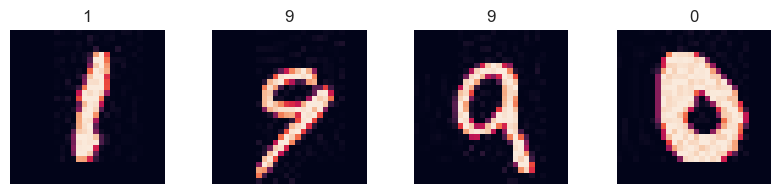

In [13]:
n_samples = 4
randoms = np.random.randint(0, len(CLASSES), n_samples)
randoms_classes = []

for i, idx in enumerate(randoms):
    randoms_classes.append(CLASSES[idx])

plt.figure(figsize = (10,2))

# Display 4 picture of the dataset with their labels
for cont, i in enumerate(randoms_classes):
    plt.subplot(1,4,cont+1)
    img = view_random_image(target_dir = DATASETS_ROOT_FOLDER + DATASET_FOLDER,
                            target_class = str(i))


## Data Preprocessing

In [14]:
# Resize of layers and 1./255 done in the datagen
# Also de data augmentation

## Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

Batch size : BATCH_NUMBER (64)
Epochs : EPOCHS
Input Shape : (WIDTH, HEIGHT, CHANNEL_NUMBER) (28,28,1)
Output layer : CLASS_NUMBER

In [15]:
# Load the pretained model
'''pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, N_CHANNELS),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False



inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(400, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)


'''

"pretrained_model = tf.keras.applications.MobileNetV2(\n    input_shape=(IMG_WIDTH, IMG_HEIGHT, N_CHANNELS),\n    include_top=False,\n    weights='imagenet',\n    pooling='avg'\n)\n\npretrained_model.trainable = False\n\n\n\ninputs = pretrained_model.input\nx = resize_and_rescale(inputs)\n\nx = Dense(256, activation='relu')(pretrained_model.output)\nx = Dropout(0.2)(x)\nx = Dense(256, activation='relu')(x)\nx = Dropout(0.2)(x)\n\n\noutputs = Dense(400, activation='softmax')(x)\n\nmodel = Model(inputs=inputs, outputs=outputs)\n\n\n"

In [16]:
'''# Create the model

# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.InceptionV3(include_top= False,)

# 2. Freeze the base model
base_model.trainable = False

#3. Create inputs into models
inputs = tf.keras.layers.Input(shape =(IMG_HEIGHT,IMG_WIDTH,N_CHANNELS), name = "input-layer")

#4. Rescaling -> it has been done already
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

#5. Pass the inputs
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(CLASS_NUMBER, activation = "softmax", name = "output-layer")(x)

# 8. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)'''


'# Create the model\n\n# 1. Create a base model with tf.keras.applications\nbase_model = tf.keras.applications.InceptionV3(include_top= False,)\n\n# 2. Freeze the base model\nbase_model.trainable = False\n\n#3. Create inputs into models\ninputs = tf.keras.layers.Input(shape =(IMG_HEIGHT,IMG_WIDTH,N_CHANNELS), name = "input-layer")\n\n#4. Rescaling -> it has been done already\n#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)\n\n#5. Pass the inputs\nx = base_model(inputs)\nprint(f"Shape after passing inputs through base model: {x.shape}")\n\n# 6. Average pool the outputs of the base model\nx = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)\nprint(f"Shape after GlobalAveragePooling2D: {x.shape}")\n\n#7. Create the output activation layer\noutputs = tf.keras.layers.Dense(CLASS_NUMBER, activation = "softmax", name = "output-layer")(x)\n\n# 8. Combine the inputs with outputs into a model\nmodel_0 = tf.keras.Model(inputs, outputs)'

In [17]:
MODEL_TO_LOAD = "/saved_models/20221128_1310_90"
# MODEL_TO_LOAD = "/saved_models/last_saved_model"

# if model_path exist, load model
if MODEL_PATH:
    print("Loading model from " + MODEL_PATH)
    model = tf.keras.models.load_model(MODEL_PATH + MODEL_TO_LOAD)
    print("Model Loaded successfully")
else:
    print("Creating Model")

    model = tf.keras.models.Sequential()
    model.add(Conv2D(32,kernel_size=3,padding='same',activation='relu',
            input_shape=(IMG_HEIGHT,IMG_WIDTH,N_CHANNELS)))
    model.add(Conv2D(64,kernel_size=3,padding='same',activation='relu'))
    model.add(MaxPool2D(padding='same'))
    model.add(Conv2D(128,kernel_size=3,padding='same',activation='relu'))
    model.add(MaxPool2D(padding='same'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(CLASS_NUMBER))

Loading model from ../../models/v6
Model Loaded successfully


In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [19]:
# Create checkpoint callback
# TODO check if just save weights or model + weight -> for the last iteration
# save also the best in precission and other metrics, not only in accuracy, si mejora en precission -> model_best_prec, etc con todas las metrics
checkpoint_path = "classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [20]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs

early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = PATIENCE_EARLY_STOPPING,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

## Training the model

Compile and training

In [21]:
training_dataset = train_augmented_tf_ds
validation_dataset = val_augmented_tf_ds

In [22]:
# 9. Compile the model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=FROM_LOGITS)
# loss = "sparse_categorical_crossentropy"
optimizer = SGD(learning_rate=0.001)
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
metrics = ["accuracy"]


model.compile(loss = loss,
                optimizer = optimizer,
                metrics = metrics)

# to measure time
start_time = time.time()

history = model.fit(
    training_dataset,
    # steps_per_epoch=len(training_dataset),
    validation_data=validation_dataset,
    # validation_steps=len(training_dataset),
    epochs=EPOCHS,
    batch_size = BATCH_NUMBER,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "mnist_classification"),
        checkpoint_callback,
    ],
    verbose = 1,
)

end_time = time.time()

Saving TensorBoard log files to: training_logs/mnist_classification/20221129-091238
Epoch 1/10
525/525 [==============================] - 208s 394ms/step - loss: 0.3477 - accuracy: 0.8915 - val_loss: 0.3475 - val_accuracy: 0.8906
Epoch 2/10
525/525 [==============================] - 61s 116ms/step - loss: 0.3382 - accuracy: 0.8964 - val_loss: 0.3259 - val_accuracy: 0.8983
Epoch 3/10
525/525 [==============================] - 59s 112ms/step - loss: 0.3345 - accuracy: 0.8972 - val_loss: 0.3326 - val_accuracy: 0.8960
Epoch 4/10
525/525 [==============================] - 59s 113ms/step - loss: 0.3245 - accuracy: 0.8997 - val_loss: 0.3187 - val_accuracy: 0.9009
Epoch 5/10
525/525 [==============================] - 64s 122ms/step - loss: 0.3178 - accuracy: 0.9031 - val_loss: 0.3021 - val_accuracy: 0.9045
Epoch 6/10
525/525 [==============================] - 58s 111ms/step - loss: 0.3150 - accuracy: 0.9015 - val_loss: 0.3091 - val_accuracy: 0.9045
Epoch 7/10
525/525 [=========================

In [23]:
# Print time of model training
print("--- %s seconds ---" % (end_time - start_time))

--- 746.1354911327362 seconds ---


## Evaluation

In [24]:
# to create the balanced dataframes:
test_df = create_balanced_dataframes(TEST_CSV, CSV_FOLDER)

# Tensorflow dataframe generation
# test_num_instances, test_tf_dataset = create_tf_ds(test_df)
test_augmented_tf_ds = create_augmented_tensorflow_dataset(test_df)

Found 1900 validated image filenames.


The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

Precision(P): The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.


Recall(R): The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.


F1 score(F1): The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.


In [25]:
test_dataset = test_augmented_tf_ds

In [26]:
results = model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.24379
Test Accuracy: 92.05%


In [33]:
# Save the weights
model.save('../../saved_models/20221129_0948_92')

INFO:tensorflow:Assets written to: ../../saved_models/20221129_0948_92\assets


INFO:tensorflow:Assets written to: ../../saved_models/20221129_0948_92\assets


### Visualizing Loss Curves

In [34]:
def plot_loss_curves(model_history):

  loss = model_history.history["loss"]
  val_loss = model_history.history["val_loss"]

  accuracy = model_history.history["accuracy"]
  val_accuracy = model_history.history["val_accuracy"]

  epochs = range(len(model_history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

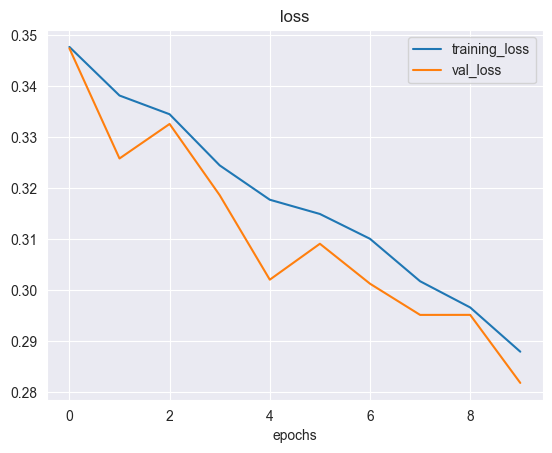

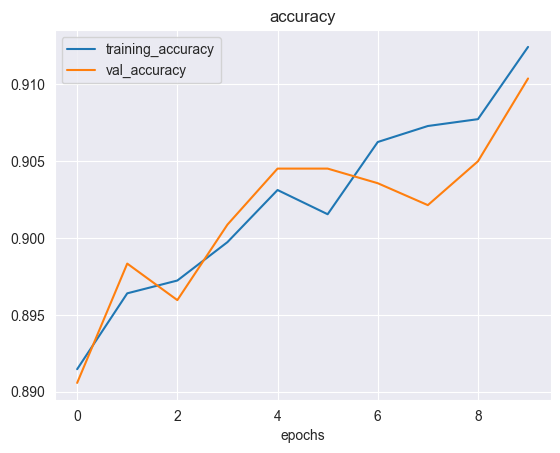

In [35]:
plot_loss_curves(history)

### Plotting the Classification Reports and Confusion Matrix

In [36]:
dataset_column = "label" # 1

def Confusion(model, pandas_dataframe, dataset):
  '''
  Función para mostrar la matriz de confusión y el reporte de clasificación de un modelo dado ante un csv

  Parámetros de entrada:
  model: modelo que se quiere probar
  csv: nombre del csv para probar el modelo

  Ejemplo de uso:
  model = tf.keras.models.load_model(os.path.join(dir_modelos, "Xcep3.h5"))

  Confusion(model, 'df_test.csv')

  '''

  # variables a utilizar
  y_true = [] # lista vacia para guardar las respuestas
  labels = pandas_dataframe[dataset_column].unique() # lista de las clases
  num_clases = len(labels)
  # num_clases = len(CLASSES)
  dicc = dict(zip(labels, list(range(num_clases)))) # diccionario con las etiquetas y su respectivo número
  lista = list(pandas_dataframe[dataset_column]) # lista con los valores reales

  # predicciones en número
  y_pred = np.argmax(model.predict(dataset), axis=-1)
  # llevo las predicciones a texto para poder comparar
  for a in lista:
    y_true.append(dicc[a])

  # Confusion Matrix
  fig, ax = plt.subplots(figsize=(7,7))
  conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_clases))
  conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
  sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False,
                cmap=plt.cm.jet, xticklabels=CLASSES, yticklabels=CLASSES,
                ax=ax)
  ax.set_ylabel('Actual')
  ax.set_xlabel('Predicted')
  ax.set_title('Confusion Matrix')
  plt.show()

  # hago el reporte de clasficación
  print('Classification Report:')
  print(classification_report(y_true, y_pred, labels=np.arange(num_clases), target_names=CLASSES))

30/30 [==============================] - 3s 83ms/step


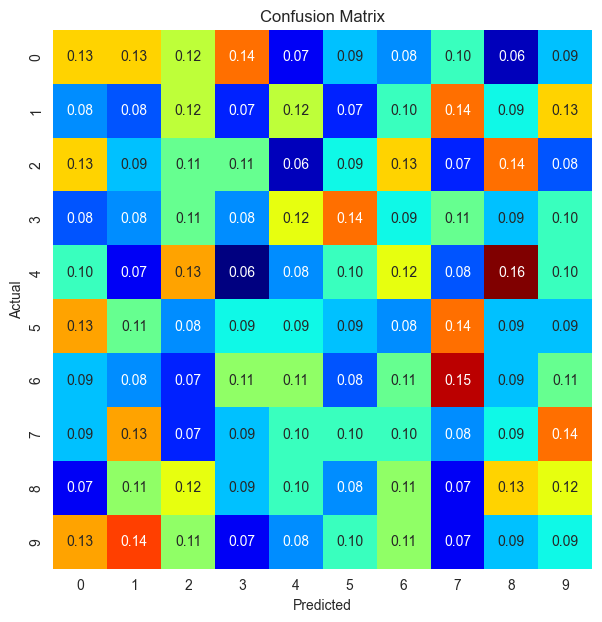

Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.13      0.12       190
           1       0.08      0.08      0.08       190
           2       0.10      0.11      0.10       190
           3       0.09      0.08      0.09       190
           4       0.09      0.08      0.09       190
           5       0.09      0.09      0.09       190
           6       0.10      0.11      0.10       190
           7       0.08      0.08      0.08       190
           8       0.12      0.13      0.12       190
           9       0.09      0.09      0.09       190

    accuracy                           0.10      1900
   macro avg       0.10      0.10      0.10      1900
weighted avg       0.10      0.10      0.10      1900



In [37]:
Confusion(model, test_df, test_dataset)

99/99 [==============================] - 5s 52ms/step


ValueError: Found input variables with inconsistent numbers of samples: [5700, 6305]

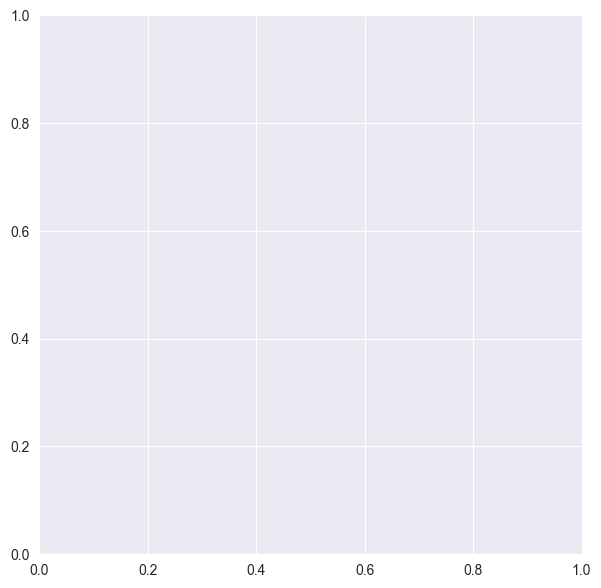

In [39]:
Confusion(model, val_df, validation_dataset)